## <strong> 0. Abstact </strong>

**Fast R-CNN vs RCNN**

* R-CNN에 비해 VGG16 network를 9배 가량 빠르게 학습시킨다.
* test-time이 213배 가량 빠르다
* PASCAL VOC 2012에 대해 더 높은 mAP를 얻는다. 

**Fast R-CNN vs SPPnet**

* SPPnet에 비해 VGG16 network를 3배 가량 빠르게 학습시킨다.
* test-time이 10배 가량 빠르다.


## <strong> 1. Introduction </strong>

최근에 깊은 ConvNet들은 image classification과 object detection 정확도를 상당히 개선했다. <br> 
image classification은 object detection과 비교해 해결하는 데 더 많은 complex를 요구하는 어려운 task다. <br>
이런 complexity 때문에, 최근에는 느리고 매력적이지 않은 **multi-stage piplines를 사용해 model을 학습시킨다.**

Complexity는 **detection은 objects의 정확한 localization**와 두 가지 주요한 과제 때문에 발생한다. <br>
첫 번째, **수 많은 후보 object location들을 처리해야 한다.** <br>
두 번째, **이 candidate들은 정확한 localization을 얻기 위해 정제되어야 하는 rough한 localization이다.** <br>
이 문제들을 위한 해결책은 speed, accuracy, simplicity를 타협하는 것이다.

이 논문에서 연구진들은 최신식 art ConVNet기반 object detector들을 위해 훈련 과정을 간소화했다. <br>
연구진들은 object proposal 분류와 그들의 spatial location을 정제하는 것을 함께 수행하는 **single-state training algorithm을 제안했다**고 한다.

그 결과로 깊은 detection network를 R-CNN에 비해 9배, SPPnet보다 3배 빠르게 학습할 수 있었다. <br>
Runtime시, PASCAL VOC 2012의 mAP를 66%(62% for R-CNN) 달성하여 top accuracy를 달성하는 동시에 **detection network는 image들을 0.3s 만에 처리한다**고 한다.


<h3> <strong> 1.1 R-CNN and SPPnet </strong> </h3>

Region-based Convolutional Network 방식(R-CNN)은 object proposal 분류를 위해 깊은 ConvNet을 사용하여 훌륭한 object detection accuracy를 기록했다. <br>
그러나 R-CNN은 다음과 같은 문제점이 존재한다.

* **Training is a multi-stage pipline** <br>
R-CNN은 처음에 log loss를 사용하여 object proposal에서 ConvNet 하나를 finetune한다. <br>
이후 fine-tuning으로 학습된 softmax classifier를 SVMs로 대체하여 object detector로 사용한다. <br>
그리고 세 번째 훈련 단계에서 bounding-box regressor들이 학습된다.
* **Training is expensive in sapce and time** <br>
SVM과 bounding-box regressor 학습을 위해 각 image의 object proposal로 부터 feature들을 추출하고 disk에 작성해야 한다. <br>
VGG16과 같이 깊은 network와 더불어 이 과정은 VOC07 trainval set의 5K image들에 대해 2.5 GPU-days가 소요된다. <br>
이 feature들은 저장소에 수백 gigiabyte를 요구한다.
* **Object detection is slow** <br>
test-time때, 각 test image들의 object proposal에서 feature들이 추출된다. <br>
VGG16을 사용한 detection은 47s/image를 소요한다.

[참고] GPU-days: 1개의 gpu 를 사용한다고 했을 때 며칠이 걸리는지를 나타내는 단위



R-CNN은 sharing computation없이 각 object proposal에 대해 forward pass를 수행하므로 느리다. <br>
**Spatial pyramid pooling networks(SPPnets)는 sharing computation으로 R-CNN의 속도를 개선하기 위해 제안되었다.** <br>
SPPnet은 전체 입력 image에 대한 convolutional feature map을 계산하고 공유된 feature map로 부터 추출된 feature vector를 사용하여 각 object proposal을 분류한다. <br>
해당 proposal 내부에서 고정된 출력으로 feature-map의 일부에 max-pooling을 수행하여 하나의 proposal에 대한 feature들이 추출된다. <br>
여러 output size들은 pool되고 spatial pyramid pooling으로 concatenate된다. <br>
SPPnet은 test-time을 10~100배 빠르게 R-CNN을 개선했다. <br>
training time도 더 빠른 proposal feature 추출로 인해 3배 가량 감소했다. <br>
SPPnet 또한 단점을 가진다. <br>
R-CNN과 같이 training이 feture들을 추출하고, log loss를 사용해 network를 fine-tuning하고, SVMs와 bounding-box regressors를 훈련시키는 multi-stage pipeline으로 진행된다. <br>
마찬가지로 feature들은 disk에 저장된다. <br>
그러나 R-CNN과 다르게 spatial pyramid pooling 앞에 있는 Conv layer의 학습을 하지 않도록 fine-tuning을 진행했다. <br>
당연하게도, 고정된 Conv layer들은 깊은 network의 정확도를 제한했다.

<h3> <strong> 1.2 Contributions </strong> </h3>

연구진들은 speed와 accuracy를 향상하는 동시에 R-CNN과 SPPnet의 단점을 보완하는 training algorithm을 제안했다. <br>
train과 test가 비교적 빠르므로 **Fast R-CNN**이라고 부른다고 한다. <br>
Fast R-CNN은 다음과 같은 이점을 가진다.

* **Higher detection quality than R-CNN, SPPnet**
* **Training is single-stage, using a multi-task loss**
* **Training can update all network layers**
* **No disk storage is required for feature caching**

## <strong> 2. Fast R-CNN architecture and training </strong>

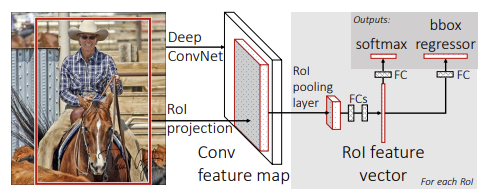

위 사진은 Fast R-CNN architecture를 묘사한 사진이다. <br>
Fast R-CNN network는 전체 image와 object proposal 세트를 받아들인다. <br>
network는 feature map을 얻기 위해 첫 번째로 몇 개의 conv layer와 max-pooling layer를 이용해 전체 이미지를 처리한다. <br>
그리고 feature map으로 부터 **region of interst(RoI)인 각 object proposal**에 대해 pooling layer로 고정된 길이의 feature vector를 추출한다. <br>
각 feature vector는 마지막으로 두 형제 출력(sibling ouput) layer로 이어지는 일련의 fc layer로 입력된다.

* 한 layer는 K개의 object class들과 background에 대한 softmax 확률 추정치를 출력한다. 
* 다른 layer는 4개의 실수(real-valued number)를 출력한다. <br>
4개의 값은 K개의 class중 하나에 위치한 제정된 bouding-box를 encoding한다.

<h3> <strong> 2.1. The RoI pooling layer </strong> </h3>

RoI pooling layer는 H×W로 고정된 공간 크기를 사용하여 작은 feature map의 RoI 내부의 feature들을 변형하기 위해 max pooling을 사용한다. <br>
단, H와 W는 hyper-parameter이다. <br>
논문에서 RoI는 conv feature map의 직사각형 window이다. <br>
각 RoI는 four-tuple (r, c, h, w)로 정의된다.

* top-left corner: (r, c)
* height and width: (h, w)

RoI max pooling은 h×w RoI window를 h/H×w/W에 근사하는 크기를 가진 sub-window들의 H×W grid로 나눔으로써 작동한다. <br>
그리고 각각의 sub-window의 값들을 output grid cell과 일치하도록 max-pooling 한다. <br>
Pooling은 기존 max pooling과 같이 각 feature map channel에 독립적으로 적용된다. <br>
**RoI layer는 SPPnet에서 사용된 spatial pyramid pooling layer에 단 하나의 pyramid level만 존재하는 special-case일 뿐이다.** <br>
연구진들은  

**[정리]**

RoI pooling은 feature map에서 region proposal에 해당하는 RoI를 지정한 크기의 grid로 나눈 후 max pooling을 수행하는 방법이다. <br>
각 channel 별로 독립적으로 수행하며 고정된 크기의 feature map을 출력한다.

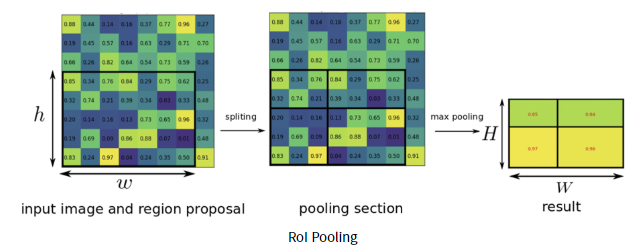


다음은 RoI pooling의 과정이다.

(1) Input image를 CNN에 통과시키고 **feature map을 얻는다.**<br>
(2) 동시에 Input image에 Selective search 알고리즘을 적용해 **region proposal들을 얻는다.**<br>
(3) **feature map에서 region proposal에 해당하는 영역을 추출한다.(h×w)** <br>
(4) 추출한 RoI feature map을 지정한 sub-window의 크기에 맞게 **(h/H)×(w/H) 크기로 grid를 생성한다.** <br>
(5) 각 grid의 셀에 대해 **max-pooling을 수행해 고정된 크기(H×W)의 feature map을 얻는다.**

<h3> <strong> 2.2. Initializing from pre-trained networks </strong> </h3>

연구진들은 5개의 pooling layer와 5~13개의 conv layer를 가진 세 가지 pre-train된 ImageNet network를 실험했다고 한다. <br>
pre-train된 network를 초기화 할 때 세 가지 변형을 시도했다고 한다.

* 첫 번째, 마지막 max-pooling layer를 H와 W가 첫 번째 fc layer와 견줄만 하게 설정된 RoI pooling layer로 대체한다.
* 두 번째, network의 마지막 fc layer와 softmax를 이전에 언급한 두 개의 sibling layer로 대체한다. <br>
(K+1개의 category를 분류하는 fc layer+softmax layer와 bounding-box regressor로 대체한다.)
* 세 번째, network가 두 개의 data를 입력 받도록 수정한다. (image 리스트와 해당 image들의 RoI리스트)

<h3> <strong> 2.3. Fine-tuning for detection </strong> </h3>

모든 weights를 back-propagation을 사용하여 훈련하는 것은 Fast R-CNN의 중요한 능력이다. <br>
첫 번째로 왜 SPPnet이 spatial pyramid pooling layer 아래에서 weight를 갱신하지 않았는지 살펴보자.

근본적인 원인은 각 training sample(i.e. RoI)이 다른 image에서 나올 때 SPP layer를 통한 back-propagation이 매우 비효율적이기 때문이었다. <br> 
실제로 R-CNN과 SPPnet은 이와 같은 방식으로 훈련되었다. <br>
이 비효율성은 각 RoI가 매우 큰 receptive field를 가지기 때문에 생겨난다. <br>
foward pass는 전체 receptive field를 처리해야 하므로 training input들이 크다.

연구진들은 학습시 feature sharing의 이점을 가지는 효율적인 training 방법을 제안한다. <br>
**Fast R-CNN 학습시 SGD mini-batches는 N개의 image와 각 image에서 R/N개의 RoI를 뽑음으로써 hierarchical하게 추출된다.** <br>
동일 이미지의 RoI들은 forward와 backward 과정에서 computation과 memory를 공유한다. <br>
N을 작게 만드는 것이 mini-batch 연산을 감소시킨다. <br>
예를 들어, N=2, R=128일 때 제시된 이론은 128개의 이미지에서 하나의 RoI를 뽑는 것보다 64배 빠르다.

이 방식에 한 가지 걱정은 같은 이미지의 RoI는 연관(correlated)되어 있으므로 slow training convergence를 유발할 수 있냐는 것이다. <br>
이 문제는 현실적이지 않으며 실제로 연구진들은 N=2, R=128로 지정하여 R-CNN보다 더 적은 SGD iteration을 수행했을 때 좋은 결과를 얻었다고 한다.

추가적으로 Fast R-CNN은 softmax classifier, SVMs, regressor 세가지 stage로 훈련시키는 것 보다 softmax classifier와 bounding-box regressors를 함께 optimize시키는 one stage 방식으로 간소화시켰다. <br>

> **[Multi-task loss]**
>
>Fast R-CNN network는 두 개의 sibling output layer를 가진다. <br>
첫 번째 layer는 $p=(p_0, …, p_K)$와 같이 K+1개의 category에 대해 이산 확률 분포를 반환한다. <br>
일반적으로 p는 fc layer의 K+1개의 output에 대한 softmax 연산으로 계산된다. <br>
두 번째 layer는 각 K object class에 대해 k로 인덱싱된 $t^k = (t^k_x, t^k_y, t^k_w, t^k_h)$와 같이 bounding-box regression offset들을 반환한다. <br>
$t^k$는 scale-invariant translation과 object proposal에 관한 log-space height/width shift를 명시한다.
>
>각 training RoI는 ground-truth class u와 ground-truth bounding-box regression target v로 라벨링된다. <br>
**연구진들은 classification과 bounding-box regression을 함께 학습시키기 위해 각 RoI들에 대해 multi-task loss L을 사용했다.**
>
>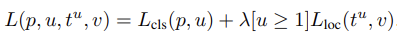
>
>$L_{cls}(p, u)=-log \, p_u$로 true class u에 대한 log loss를 의미한다. <br>
$L_{loc}$은 $class \, u, v = (v_x, v_y, v_w, v_h)$에 대한 true bounding-box regression target과 $class \, u$에 대해 예측된 $tuple \, t^k = (t^k_x, t^k_y, t^k_w, t^k_h)$으로 정의된다. <br>
$[u ≥ 1]$은 u≥1를 만족하면 1 이외에는 0으로 평가한다. <br>
관습으로 catch-all background class는 u=0으로 라벨링 된다. <br>
background RoI에 대해 ground-truth bounding-box 라는 개념이 없고 그러므로 $L_{loc}$는 무시된다. <br>
bounding-box regression에 대해 우리는 다음과 같은 loss를 사용한다.
>
>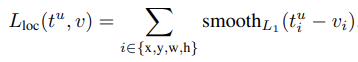
>
>smooth함수는 다음과 같다.
>
>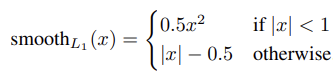
>$L_2$ loss에 비해 outlier에 대해 덜 민감한 $L_1$ losssms R-CNN과 SPPnet에 사용된다. <br>
regression target이 unbounded되었을 때 exploding gradient를 예방하기 위해 $L_2$ loss는 세심한 learning rate tuning이 필요할 수 있다. <br>
위에서 smooth 함수가 이 sensitivity를 예방한다. 
>
>첫 번째 식에 있는 hyper-parameter $λ$는 두 task loss들을 조정하는 역할을 한다. <br>
연구진들은 평균 0, 분산 1을 가지도록 ground-truth regression target $v_i$를 normalize했다고 한다. <br>
모든 실험에서는 $λ=1$로 사용했다고 한다.

>**[Mini-batch sampling]**
>
> fine-tuning 동안 각 SGD mini-batch는 균일하게 random으로 선택된 N=2개의 image로 구성되었다.(흔한 practice이므로 dataset의 permutation들을 반복했다고 한다.)<br>
연구진들은 mini-batch의 size R=128, sampling RoIs=64로 지정했다고 한다. <br>
또한 ground-truth bounding box와 intersection over union(IoU) overlap이 최소한 0.5인 object proposal들로 RoI의 25%를 구성했다. <br>
이 RoI들은 u≥1인 foreground object class로 labeling된 exmaple들로 구성된다. <br>
나머지 RoI들은 0.1이상 0.5이하를 만족하는 IoU를 가지는 object proposal들로 부터 sampling된다. <br>
이들은 background example들로 u=0으로 labeling된다. <br>
0.1보다 더 작은 임계값(threshold)는 어려운 example 탐색으로 스스로 학습하는 역할을 한다. <br>
training 동안, image들은 0.5 확률로 horizontally flip된다. <br>
다른 data augmentation은 사용되지 않았다고 한다.






>**[SGD hyper-parameters]**
>
> * Fc layers in softmax, bounding-box regression: 
initialized from zero-mean Gaussian distributions with standard deviations 0.01 and 0.001
* Biases: initialized to 0
* All layers: per-layer learing rate for weights-1, for biases-2 / global learning rate-0.001
* If training data is large run SGD for more iterations
* momentum-0.9 / parameter decay-0.0005

<h3> <strong> 2.4. Scale invariance </strong> </h3>

연구진들은 scale invariant object dectection을 달성하기 위해 두 가지 방식을 사용했다고 한다. 

* via brute force learning
* by using image pyramids

brute force 방식에서 각 image는 train과 test때 미리 지정된 pixel size로 처리된다. <br>
이 networks는 training data로 부터 scale invarient object dectection을 직접적으로 학습한다.

multi-scale approach 방식은 image pyramid를 통해 network에서 거의 정확한 scale-invariance를 제공한다. <br>
test-time때, image pyramid는 각 object proposal의 크기를 normalize하는데 사용한다. <br>
multi-scale training 동안, 연구진들은 무작위로 pyramid scale을 뽑았다고 한다. <br>
단, multi-scale의 경우 GPU memory 제한 때문에 더 작은 network를 사용했다고 한다.

## <strong> 3. Truncated SVD for faster detection </strong>

전체 image classification 동안 fc layer에 소비되는 시간은 conv layer에 비해 적다. <br>
하지만 detection시 RoI를 처리할 때 fc layer에서 많은 시간을 소비한다. <br>
이를 위해 연구진들은 **Truncated SVD(Singular Vector Decomposition)**을 제시한다.

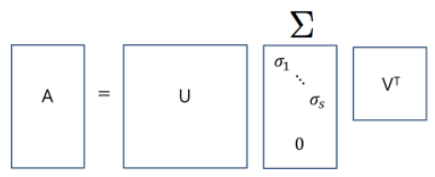

위처럼 임의의 행렬 A는 m×m 행렬 U, m×n ∑, n×n $V^T$로 특이값 분해(SVD)하는 것을 **Full SVD**라고 한다. <br>
하지만 위와 같이 하는 경우는 드물며, 분해된 행렬 중 일부만을 활용하는 reduced SVD(i.e. Truncated SVD)을 많이 사용한다고 한다. 

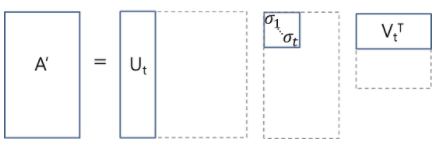

Truncated SVD는 ∑의 배대각 부분과 대각 원소 중 특이값이 0인 부분을 모두 제거하고 제거된 ∑에 대응되는 U, V원소도 함께 제거하여 차원을 줄인다. 이렇게 하면 행렬 A에 상당히 근사할 수 있다고 한다. 이때 $U_t$는 m×t, $∑_t$는 t×t, $V^t$는 t×n의 크기를 가진다. 

만약 fc layer 가중치 행렬에 위를 적용시키면 파라미터 수를 줄일 수 있다.

Truncated SVD 참고: https://herbwood.tistory.com/8

## <strong> 4. Conclusion </strong>

Fast R-CNN은 다음과 같은 이유로 성능 개선이 가능했다.

* RoI Pooling을 사용해 2000번의 CNN 연산을 1번의 CNN 연산으로 줄였다.
* multi-loss를 사용하여 end-to-end 학습이 가능하다.

하지만 다음과 같은 단점이 아직 존재한다.

* RoI를 생성하는데 Selective Search 알고리즘이 CNN 외부에서 진행된다. 즉, bottleneck이 발생한다. <br>
실제로 이미지 한 장당 2.3s의 test time이 소요된다. (2초 가량이 bottleneck 때문에 발생한다.)

이후 위 단점을 보완하여 RoI생성을 CNN 내부에서 수행하여 더 빠르고 정확한 region proposal을 생성하는 Faster R-CNN이 등장한다.